# Cancer Type Classification using Deep-Learning
## S.Ravichandran

This document will explain how to use genomic expression data for classifying different cancer/tumor sites/types. This workshop is a follow-up to the NCI-DOE Pilot1 benchmark also called TC1. You can read about the project here, https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/TC1

For classification, we use a Deep-Learning procedure called 1D-Convolutional Neural Network (CONV1D; https://en.wikipedia.org/wiki/Convolutional_neural_network. 
NCI Genomic Data Commons (GDC; https://gdc.cancer.gov/) is the source of RNASeq expression data. 

First we will start with genomic data preparation and then we will show how to use the data to build CONV1D model that can classify different cancer types. Please note that there are more than ways to extract data from GDC. What I am describing is one possible way. 

This is a continuation of data preparation which can be accessed from here, 
https://github.com/ravichas/ML-TC1

# Part-2: Convolutional Neural Network

## Load some libraries

In [2]:
from __future__ import print_function
import os, sys, gzip, glob, json, time, argparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Let us read the input data and outcome class data

In [3]:
# Read features and output files
TC1data3 = pd.read_csv("Data/TC1-data3stypes.tsv", sep="\t", low_memory = False)
outcome = pd.read_csv("Data/TC1-outcome-data3stypes.tsv", sep="\t", low_memory=False, header=None)

In [4]:
TC1data3.iloc[[0,1,2,3,4],[0,1,2,3,4,5,6,7,8,9,60400,60401,60482]]

,0,1,2,3,4,5,6,7,8,9,60400,60401,60482
0,1.716923,0.0,1.951998,1.167483,0.667981,1.274099,1.258272,1.837351,1.000251,1.991821,0.0,0.0,0.0
1,1.979573,0.0,1.939303,0.946014,0.828050,1.338521,1.215231,2.298950,1.974058,1.744890,0.0,0.0,0.0
2,1.681222,0.0,2.016686,0.789298,0.930981,1.167504,1.026718,2.058239,1.776646,1.510484,0.0,0.0,0.0
3,1.640044,0.0,1.669994,0.821958,0.426876,1.214174,1.673027,1.904529,0.867674,1.526440,0.0,0.0,0.0
4,1.800725,0.0,2.013062,0.743211,0.652487,0.935054,1.102839,2.068075,1.405575,1.674716,0.0,0.0,0.0


In [5]:
# outcome[0].value_counts()
outcome = outcome[0].values

In [6]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [7]:
# One hot encoding 
# Done run more than once 
outcome = encode(outcome)

Shape of data (BEFORE encode): (150,)
Shape of data (AFTER  encode): (150, 3)



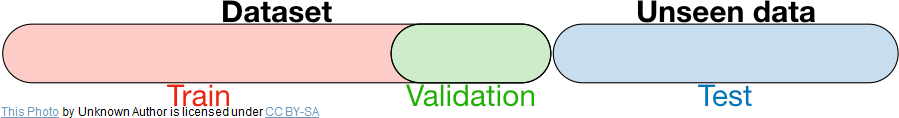

In [8]:
from IPython.core.display import Image
Image(filename='Img/Train-Test.png',width = 600, height = 800 )

You can use the Test data for validatation. 

## Split the data into training and test set

In [9]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(TC1data3, outcome,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123,
                                                    stratify = outcome)

## Let us define some parameters

* activation to be RELU
* batch_size is set to 20 
* number of classes is three (chosen a small number for performace) for this exercise. The code that is available from NIH FTP site will model 15 cancer site outputs.

In [9]:
# parameters
activation='relu'
batch_size=20
# Number of sites
classes=3

drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'

# metrics='accuracy'
out_act='softmax'

shuffle = False

### Note epochs should be greather than 10. For hands-on, I have chosen a smaller number

In [10]:
epochs=5
optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [11]:
x_train_len = X_train.shape[1]

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

### Please note that the `filters = 128` gave the best results. For the purpose of demonstration via cloud, I might choose a smaller number.

In [12]:
# filters = 128
filters = 128
filter_len = 20
stride = 1

# ALW: Commenting this out because otherwise this line is causing the error in older Keras/TF versions: "ValueError: Tensor("training/SGD/Variable:0", shape=(20, 1, 128), dtype=float32_ref) must be from the same graph as Tensor("SGD/momentum/read:0", shape=(), dtype=float32)."
#K.clear_session()

## Create and initialize the model

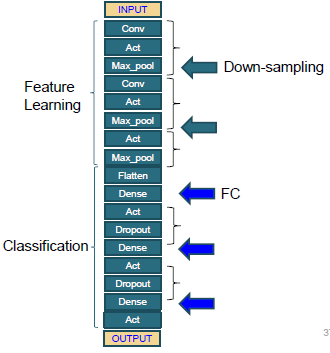

In [13]:
from IPython.core.display import Image
Image(filename='Img/TC1-arch.png',width = 300, height = 400 )

In [14]:
model = Sequential()

# model.add  1. CONV1D
model.add(Conv1D(filters = filters,
                 kernel_size = filter_len,
                 strides = stride,
                 padding='valid',
                 input_shape=(x_train_len, 1)))

## Create the topology of the architecture

In [15]:
# 2. Activation
model.add(Activation('relu'))

# 3. MaxPooling
model.add(MaxPooling1D(pool_size = 1))

# 4. Conv1D: filters:128, filter_len=20, stride=1
model.add(Conv1D(filters=filters,
                 kernel_size=filter_len,
                 strides=stride,
                 padding='valid'))

# 5. Activation
model.add(Activation('relu'))

# 6. MaxPooling
model.add(MaxPooling1D(pool_size = 10))

# 7. Flatten
model.add(Flatten())

# 8. Dense
model.add(Dense(200))

# 9. activation
model.add(Activation('relu'))

# 10. dropout
model.add(Dropout(0.1))

#11. Dense
model.add(Dense(20))

#12. Activation
model.add(Activation('relu'))

#13. dropout
model.add(Dropout(0.1))

# 14. dense
model.add(Dense(3))

# 15. Activation
model.add(Activation(out_act))

## Compile and show the model summary

In [16]:
model.compile( loss= loss,
              optimizer = optimizer,
              metrics = metrics )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60464, 128)        2688      
_________________________________________________________________
activation_1 (Activation)    (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60464, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60445, 128)        327808    
_________________________________________________________________
activation_2 (Activation)    (None, 60445, 128)        0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6044, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 773632)            0         
__________

In [17]:
# save
save = '.'
output_dir = "Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [18]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              verbose=1, mode='auto',
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0)

### This is a time-consuming step and smaller sample sizes will not result in good model. 
Here are the commands for training and evaluating test accuracy score.

In [19]:
# batch_size = 20; epochs=5
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test),
                    callbacks = [checkpointer, csv_logger, reduce_lr])

Train on 112 samples, validate on 38 samples
Epoch 1/5
112/112 [==============================] - 60s 537ms/step - loss: 1.5190 - acc: 0.4107 - val_loss: 1.0976 - val_acc: 0.3158

Epoch 00001: val_loss improved from inf to 1.09760, saving model to Model/tc1.autosave.model.h5
Epoch 2/5
112/112 [==============================] - 62s 551ms/step - loss: 1.1407 - acc: 0.4107 - val_loss: 1.4496 - val_acc: 0.6316

Epoch 00002: val_loss did not improve from 1.09760
Epoch 3/5
112/112 [==============================] - 55s 489ms/step - loss: 1.2153 - acc: 0.2679 - val_loss: 1.0948 - val_acc: 0.3158

Epoch 00003: val_loss improved from 1.09760 to 1.09483, saving model to Model/tc1.autosave.model.h5
Epoch 4/5
112/112 [==============================] - 55s 495ms/step - loss: 1.1007 - acc: 0.3393 - val_loss: 1.0633 - val_acc: 0.3947

Epoch 00004: val_loss improved from 1.09483 to 1.06333, saving model to Model/tc1.autosave.model.h5
Epoch 5/5
112/112 [==============================] - 55s 489ms/step 

In [20]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.0602983110829403
Test accuracy: 0.3157894736842105


## Word of caution about the accuracy

The output loss and accuracy from smalller sample sizes (for example, n = 50) will not reflect the real learning. For good accuracy, we need to use the whole dataset. Here are few epochs from the original dataset modeling (Train: 3375; Validate: 1125).

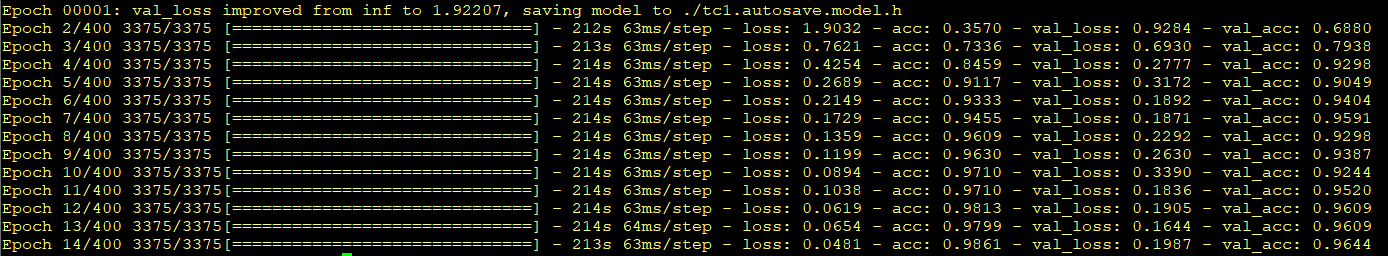

In [21]:
from IPython.core.display import Image
Image(filename='Img/TC1-Acc.PNG',width = 1000, height = 1000 )

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tc1results = pd.read_csv("Output/tc1results.txt", index_col='epoch')

<AxesSubplot:xlabel='epoch'>

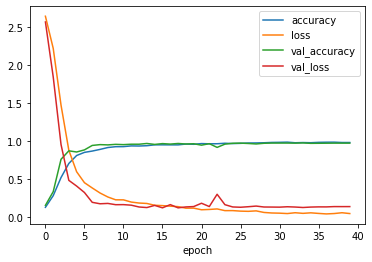

In [24]:
tc1results.plot()

## How to save the model/weights?

In [25]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('Model/tc1.model.json', 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir, model_name))
print("Saved model to disk")

# ALW: Also saving model using model.save('path/to/location') as model.save() is different from model.save_weights()
full_model_hdf5_file = '{}/{}.full_model.h5'.format(output_dir, model_name)
model.save(full_model_hdf5_file)
print('Full model also saved to {}'.format(full_model_hdf5_file))

Saved model to disk
Full model also saved to Model/tc1.full_model.h5


## Inference

The calculation was carried out on a NIH Biowulf GPU node. Model weights were saved in Python HDF5 grid format. HDF5 is ideal for storing multi-dimensional arrays of numbers. You can read about HDF5 here.
http://www.h5py.org/

In [26]:
from keras.models import model_from_json

# Open the handle
json_file = open('Model/tc1.model.json', 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('Model/tc1.model.h5')
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


## Mimicking the process of external set

Note this is a demonstration of how to use external data for inference.  

When you bring in an external dataset. Make sure you follow the following steps:

a) Make sure you do the same operations that you had done to the data set 
b) scale the inference dataset in the same way as the training data 


In [27]:
import numpy as np
chosen_idx = np.random.choice(38, replace=False, size=5)
# X_test[chosen_idx].shape
# Y_test[chosen_idx].shape
# Y_test.shape

In [28]:
X_mini = X_test[chosen_idx]
y_mini = Y_test[chosen_idx]
# df_trimmed = X_mini.drop(X_mini.columns[[0]], axis=1, inplace=False)
# X_mini = df_trimmed
print('X_mini.shape', X_mini.shape)
print('len(y_minip)', len(y_mini))

X_mini.shape (5, 60483, 1)
len(y_minip) 5


In [29]:
print('X_mini.shape', X_mini.shape)
print('y_mini.shape', y_mini.shape)

X_mini.shape (5, 60483, 1)
y_mini.shape (5, 3)


In [30]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_mini, y_mini, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 40.00%


## Unsupervised learning plots (PCA and tSNE)

### *This section was based on Dr. Andrew Weisman's code template. Check out Andrew's Gihub here, https://github.com/andrew-weisman*

### Load the custom `tc1_library.py` file, which contains the unsupervised learning plotting function

In [31]:
import tc1_library
import importlib

importlib.reload(tc1_library);

### Decode the outcome matrix back into a single vector (remember earlier that we one-hot-encoded it)

In [32]:
outcome[0:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

##### Let us explore some outcome values

In [33]:
outcome.shape # 150,3
outcome[0:3]  
outcome[50:53]  
outcome[75:80]  

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

##### Let us explore some outcome_decoded values

In [34]:
outcome_decoded = [x.argmax() for x in outcome]

In [35]:
outcome_decoded[0:3] #[1,1,1]
outcome_decoded[50:53] #[2,2,0]
outcome_decoded[75:80] # [0, 0, 0, 0]

[0, 0, 0, 0, 0]

### Perform the PCA and t-SNE using scikit-learn

Top 10 PCA explained variance ratios: [0.38811713 0.12041275 0.0499922  0.03027331 0.02528322 0.02271728
 0.01852503 0.01623522 0.01457019 0.01271466]


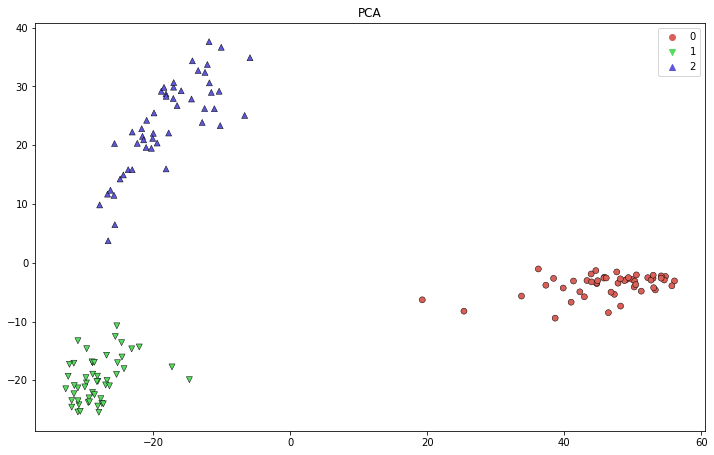

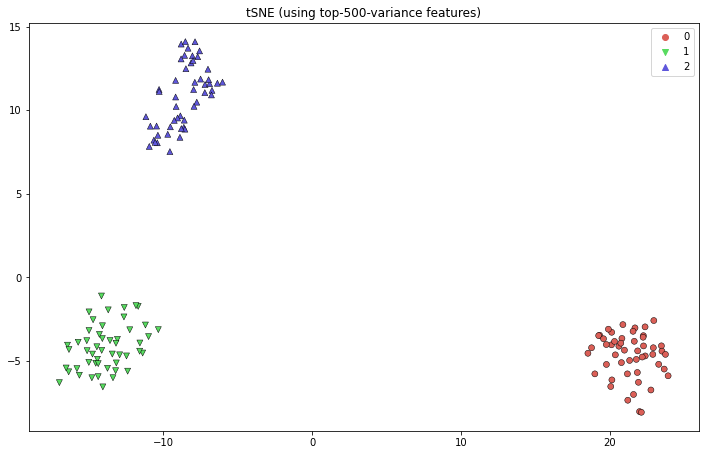

In [37]:
import sklearn.decomposition as sk_decomp
tc1_library.run_and_plot_pca_and_tsne(TC1data3, outcome_decoded)

## Create a binary dataset instead of a multi-class one

### Current outcome distribution of the 150 samples

In [38]:
pd.value_counts(outcome_decoded)

2    50
1    50
0    50
dtype: int64

### Get the indexes of the data that correspond to classes 0 or 1 only (excluding class 2)

In [39]:
binary_indexes = np.where(np.array(outcome_decoded)!=2)[0]

### Recreate the data structures of the same types that was used in the original analysis above, except this time with just two classes

In [40]:
TC1data2 = TC1data3.iloc[binary_indexes,:]
outcome2 = outcome[binary_indexes,:]

### Decode the new outcome matrix just like we did above, and print out the outcome distribution of the new set of samples

In [41]:
outcome_decoded2 = [x.argmax() for x in outcome2]
pd.value_counts(outcome_decoded2)

1    50
0    50
dtype: int64

### Check our new dataset by performing the same unsupervised learning that we did above

Top 10 PCA explained variance ratios: [0.49686232 0.04021868 0.03354305 0.0322151  0.0264985  0.01835517
 0.01706732 0.01658542 0.01310743 0.01183897]


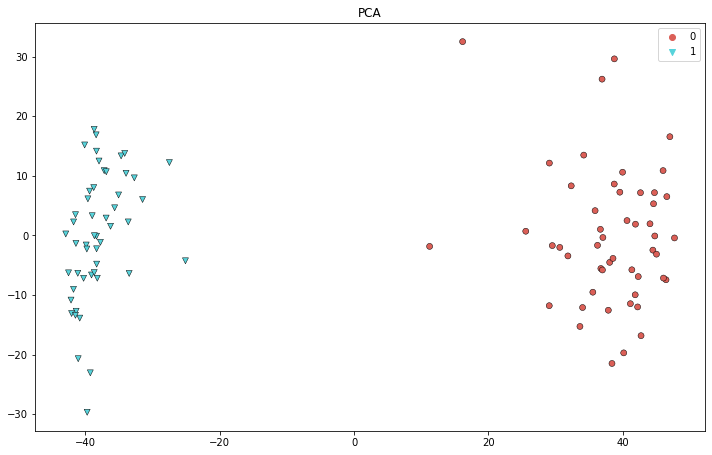

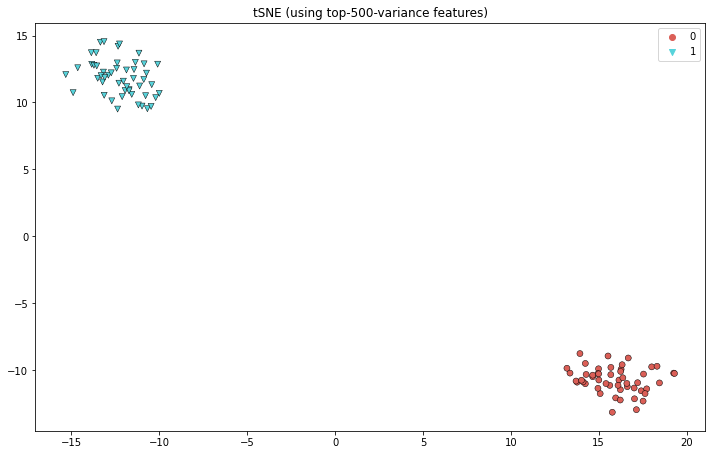

In [42]:
tc1_library.run_and_plot_pca_and_tsne(TC1data2, outcome_decoded2)

## Next Steps

* Pick up with the Jupyter notebook from the cell that splits the data into the training and test sets, but now replacing TC1data3 with TC1data2 and outcome with outcome2
* Work through the notebook until at least the model has been trained (the cell with history = model.fit(...)), resulting in a binary classifier
* Apply gene/feature importance tools to the resulting model in order to determine which genes best contribute to discriminating between cancer classes 0 and 1

## Saving two-class datafiles to disk
### Save the data and labels to CSV format in the repository's data directory

In [43]:
TC1data2.reset_index(drop=True).to_csv('Data/X_two_classes.csv')

pd.Series(outcome_decoded2).to_csv('Data/y_two_classes.csv')

Test that we've exported the data correctly by reading them back in and running the unsupervised learning analyses

Top 10 PCA explained variance ratios: [0.49686232 0.04021868 0.03354307 0.03221507 0.02649849 0.01835583
 0.01706931 0.01658852 0.01310649 0.01187091]


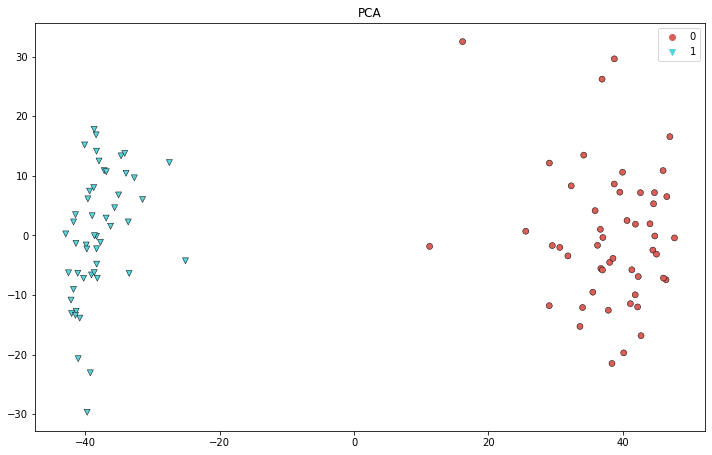

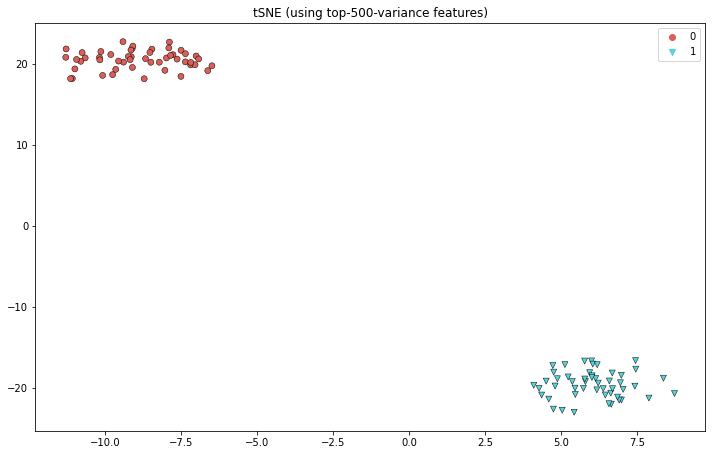

In [44]:
X = pd.read_csv('Data/X_two_classes.csv', index_col=0)

y = pd.read_csv('Data/y_two_classes.csv', index_col=0, squeeze=True)

tc1_library.run_and_plot_pca_and_tsne(X, y)

You are viewing the Jupyter Notebook from ML-TC1 GitHub repository, https://github.com/ravichas/ML-TC1 


## Trying Deeplift again now that we've made the keras/tensorflow stack as close as possible to what they suggest

In [1]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

# The following commented message from the output of the convert_model_from_saved_files() function that follows isn't true for layer max_pooling1d_2, whose next layer is flatten_1, but I assume this is okay because flatten is not a "real" layer (no connecting weights)? If flatten is indeed fine, then this is fine, because the next layer is dense_1, which, according to the output, is an allowed, linear layer.

#Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)

deeplift_model = kc.convert_model_from_saved_files('Model/tc1.full_model.h5', nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 4 the preceding linear layer is 3 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 8 the preceding linear layer is 7 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 11 the preceding linear layer is 10 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sof

In [2]:
find_scores_layer_idx = 0
deeplift_contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=find_scores_layer_idx, target_layer_idx=-2)

# #Compile the function that computes the contribution scores
# #For sigmoid or softmax outputs, target_layer_idx should be -2 (the default). This computes explanations
# # w.r.t. the logits. (See "3.6 Choice of target layer" in https://arxiv.org/abs/1704.02685 for justification)
# #For regression tasks with a linear output, target_layer_idx should be -1 (which simply refers to the last layer)
# #Note that in the case of softmax outputs, it may be a good idea to normalize the softmax logits so
# # that they sum to zero across all tasks. This ensures that if a feature is contributing equally to
# # to all the softmax logits, it will effectly be seen as contributing to none of the tasks (adding
# # a constant to all logits of a softmax does not change the output). This is discussed in
# # https://github.com/kundajelab/deeplift/issues/116. One way to efficiently acheive this
# # normalization is to mean-normalize the weights going into the Softmax layer as
# # discussed in eqn. 21 in Section 2.5 of https://arxiv.org/pdf/1605.01713.pdf ("A note on Softmax Activation")
# #If you want the DeepLIFT multipliers instead of the contribution scores, you can use get_target_multipliers_func
# deeplift_contribs_func = deeplift_model.get_target_contribs_func(
#                             find_scores_layer_idx=find_scores_layer_idx,
#                             target_layer_idx=-1)
# #You can also provide an array of indices to find_scores_layer_idx to get scores for multiple layers at once

Using TensorFlow backend.


In [15]:
import pickle
#things_to_save = [deeplift_model, deeplift_contribs_func, X_train]
things_to_save = [X_train]
with open('Data/X_train.pkl', 'wb') as f:
    pickle.dump(things_to_save, f)

In [3]:
import pickle
with open('Data/X_train.pkl', 'rb') as f:
    things_to_save = pickle.load(f)
X_train = things_to_save[0]

In [4]:
import numpy as np

# # X_train.to_numpy()[0,:]] --> (60483,) --> ValueError: Cannot feed value of shape (10,) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[0,:]], batch_size=10, progress_update=1000))

# # X_train.to_numpy()[0,:]] --> (60483,) --> ValueError: Cannot feed value of shape (1,) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[0,:]], batch_size=1, progress_update=1000))

# # X_train.to_numpy()[0,:].reshape((1,1,60483)) --> (1,1,60483) --> ValueError: Cannot feed value of shape (1, 1, 60483) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[0,:].reshape((1,1,60483))], batch_size=10, progress_update=1000))

# # X_train.to_numpy()[0,:].reshape((1,1,60483)) --> (1,1,60483) --> ValueError: Cannot feed value of shape (1, 1, 60483) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[0,:].reshape((1,1,60483))], batch_size=1, progress_update=1000))

# # X_train.to_numpy()[:5,:].reshape((5,1,60483,1)) --> (5,1,60483,1) --> ValueError: Cannot feed value of shape (1, 1, 60483, 1) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[:5,:].reshape((5,1,60483,1))], batch_size=1, progress_update=1000))

# # X_train.to_numpy()[:5,:].reshape((5,1,1,60483)) --> (5,1,1,60483) --> ValueError: Cannot feed value of shape (1, 1, 1, 60483) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[:5,:].reshape((5,1,1,60483))], batch_size=1, progress_update=1000))

# X_train.to_numpy()[:N,:].reshape((N,60483,1)) --> (N,60483,1) --> 
N = 2
scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[:N,:].reshape((N,60483,1))], batch_size=1, progress_update=1000))

# # X_train.to_numpy()[:5,:].reshape((5,1,1,60483)) --> (5,1,1,60483) --> ValueError: Cannot feed value of shape (1, 1, 1, 60483) for Tensor 'inp_input:0', which has shape '(?, 60483, 1)'
# scores_0 = np.array(deeplift_contribs_func(task_idx=0, input_data_list=[X_train.to_numpy()[:5,:].reshape((5,1,1,60483))], batch_size=1, progress_update=1000))

# #compute scores on inputs
# #input_data_list is a list containing the data for different input layers
# #eg: for MNIST, there is one input layer with with dimensions 1 x 28 x 28
# #In the example below, let X be an array with dimension n x 1 x 28 x 28 where n is the number of examples
# #task_idx represents the index of the node in the output layer that we wish to compute scores.
# #Eg: if the output is a 10-way softmax, and task_idx is 0, we will compute scores for the first softmax class
# scores = np.array(deeplift_contribs_func(task_idx=0,
#                                          input_data_list=[X],
#                                          batch_size=10,
#                                          progress_update=1000))

NameError: name 'np' is not defined

In [30]:
tmp = X_train.to_numpy()

In [31]:
tmp.shape

(112, 60483)

In [33]:
tmp.reshape((112,1,60483))[0,0,:].shape

(60483,)

In [34]:
X_train.to_numpy()[0,:].shape

(60483,)

In [38]:
X_train.to_numpy()[0,:].reshape((1,1,60483))

array([[[1.55144077, 0.        , 1.64929815, ..., 0.        ,
         0.        , 0.        ]]])

In [39]:
X_train.to_numpy()[0,:].reshape((1,1,60483)).shape

(1, 1, 60483)

In [43]:
tmp.shape

(112, 60483)

In [47]:
print(X_train.to_numpy()[:5,:].reshape((5,1,60483,1)).shape)
print(X_train.to_numpy()[:5,:].reshape((5,1,1,60483)).shape)

(5, 1, 60483, 1)
(5, 1, 1, 60483)
